In [1]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops


from system.lstmSystem import LSTMSystem
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
from system.preAndPostProcessor import PreAndPostProcessor

C:\Users\Andres\PycharmProjects\LSTMsForAudioInpainting\utils\legacy\plotSummary.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\andres\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\andres\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  Fil

In [2]:
import importlib
import system
importlib.reload(system.lstmSystem)
from system.lstmSystem import LSTMSystem
import architecture
importlib.reload(architecture.realImagContextEncoderLSTMArchitecture)
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
import system
importlib.reload(system.preAndPostProcessor)
from system.preAndPostProcessor import PreAndPostProcessor

from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture
importlib.reload(architecture.contextEncoderLSTMArchitecture)
from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture

from system.lstmSystem import LSTMSystem

In [3]:
tf.reset_default_graph()

from architecture.parameters.lstmContextInpaintingParameters import LstmContextInpaintingParameters
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
import os

from system.preAndPostProcessor import PreAndPostProcessor
from system.realImagContextLSTMSystem import RealImagContextLSTMSystem
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

sessionsName = "test_realImagContext3LSTM512_fft256_"

params = LstmContextInpaintingParameters(lstmSize=512, batchSize=64, signalLength=5120, inputChannels=4,
										 gapLength=1024, fftWindowLength=256, fftHopSize=64)

contextArchitecture = RealImagContextEncoderLSTMArchitecture(params)

aPreProcessor = PreAndPostProcessor(params)

aContextEncoderSystem = RealImagContextLSTMSystem(contextArchitecture, aPreProcessor, params, sessionsName)


In [4]:
sr = 16000
start_in_seconds = 0.1
side_length = 2048
gap_length = 1024
starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

best_step = 292000
batch_size = 64

In [55]:
pathToDatasetFolder = "../LSTMsOnSpectrograms/nsynth-test/audio"
audios = StrechableNumpyArray()
i = 0
total = 0
file_names = []
for file_name in os.listdir(pathToDatasetFolder):
    audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None)

    if np.sum(np.absolute(audio[5120:5120*2])) < 5120*1e-3: 
        print(file_name, "doesn't meet the minimum amplitude requirement")
        continue

    file_names.append(file_name)
    audios.append(audio)
    i+=1

    if i > 500:
        i -= 500
        total += 500
        print("500 plus!", total)
#         if total >= 0 and i >= 8:
#             break
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio)))
print(audios.shape)

bass_electronic_018-022-100.wav doesn't meet the minimum amplitude requirement
bass_electronic_018-023-025.wav doesn't meet the minimum amplitude requirement
bass_electronic_025-022-050.wav doesn't meet the minimum amplitude requirement
bass_electronic_027-022-050.wav doesn't meet the minimum amplitude requirement
500 plus! 500
bass_synthetic_134-080-127.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-083-100.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-086-050.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-091-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-092-050.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-093-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-093-100.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-095-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-095-100.wav doesn't meet th

500 plus! 2000
keyboard_electronic_002-103-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-104-025.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-105-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-105-100.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-106-100.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-108-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_098-108-100.wav doesn't meet the minimum amplitude requirement
500 plus! 2500
keyboard_synthetic_000-104-127.wav doesn't meet the minimum amplitude requirement
keyboard_synthetic_000-107-075.wav doesn't meet the minimum amplitude requirement
keyboard_synthetic_000-108-050.wav doesn't meet the minimum amplitude requirement
mallet_acoustic_056-033-100.wav doesn't meet the minimum amplitude requirement
mallet_acoustic_056-035-025.wav doesn't meet the minimum amplitu

In [56]:
original_signals = audios[:, starting_sample_left_side:ending_sample_right_side]
original_gaps = audios[:, ending_sample_left_side:starting_sample_right_side]

In [89]:
generatedSpecs = aContextEncoderSystem.reconstruct(original_signals, model_num=300000)

INFO:tensorflow:Restoring parameters from utils/saved_models/test_realImagContext3LSTM512_fft256_/model-test_realImagContext3LSTM512_fft256_300000.ckpt
Model restored.


In [90]:
complexGenerated = generatedSpecs[0][:, :, :, 0] + 1.0j * generatedSpecs[0][:, :, :, 1]
complexOriginal = generatedSpecs[1][:, :, :, 0] + 1.0j * generatedSpecs[1][:, :, :, 1]

plotGeneratedSpecs = np.abs(complexGenerated)
plotOriginalSpecs = np.abs(complexOriginal)
print(plotGeneratedSpecs.shape)
print(generatedSpecs[0].shape)
# len(original_signals)

(3904, 19, 129)
(3904, 19, 129, 2)


Text(0.5,1,'reconstructed')

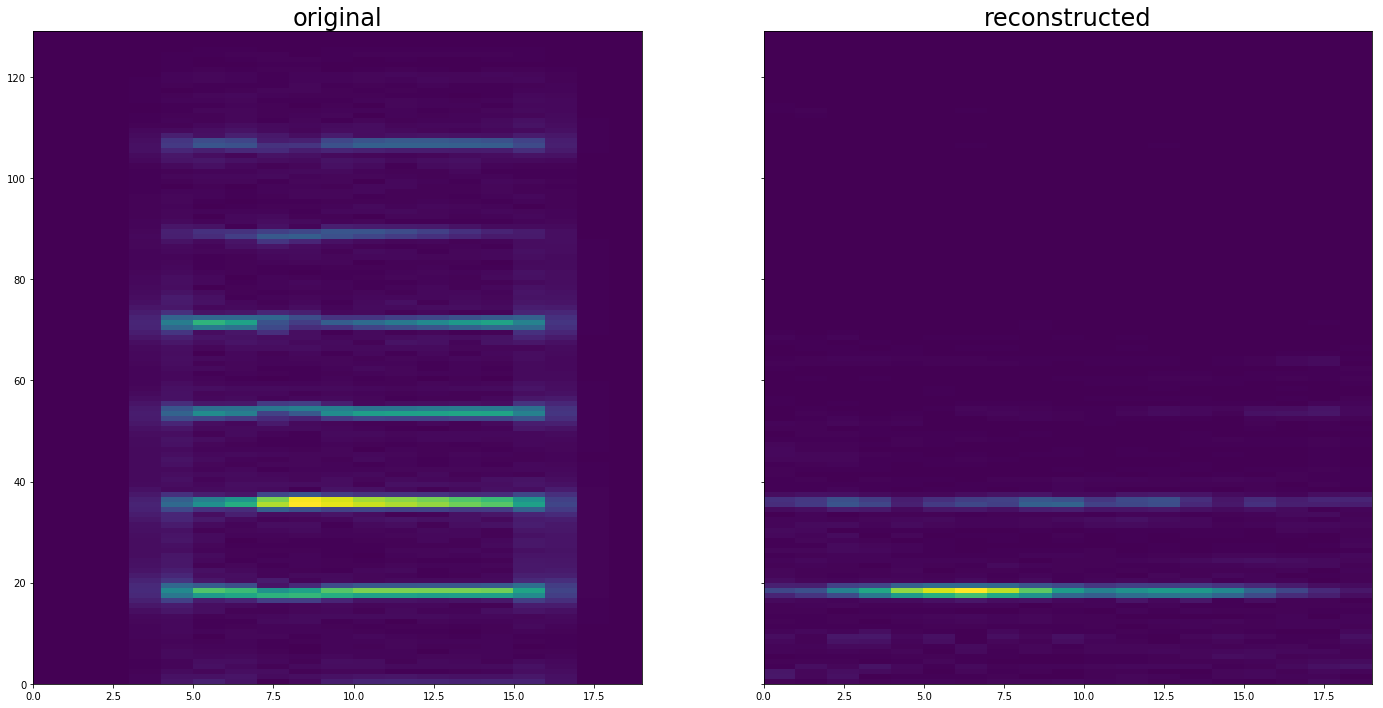

In [91]:
testOn = 255

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee

axarr[0].pcolormesh(plotOriginalSpecs[testOn].transpose())
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(plotGeneratedSpecs[testOn].transpose())
axarr[1].set_title('reconstructed', size=24)


In [92]:
window_fn = functools.partial(window_ops.hann_window, periodic=True)
inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                       forward_window_fn=window_fn)
stft_to_invert = tf.placeholder(tf.complex64, shape=complexGenerated.shape, name='stft_to_invert')
tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                          frame_step=params.fftHopSize(), window_fn=inverse_window)
with tf.Session() as sess:
    generatedTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexGenerated})
    originalTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexOriginal})

    

In [93]:
generatedTimeSignals.shape

(3904, 1408)

In [25]:
IPython.display.Audio(data=originalTimeSignals[10], rate=16000)

In [102]:
reconstructedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], generatedTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
rec_original_signals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], originalTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
zeroedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], np.zeros([len(generatedTimeSignals), 1024]), audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)

In [103]:
zeroedSignals.shape

(3904, 64000)

In [104]:
rec_original_signals.shape

(3904, 64000)

In [108]:
testOn = 255

# IPython.display.Audio(data=rec_original_signals[255], rate=16000)
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

# IPython.display.Audio(data=zeroedSignals[testOn], rate=16000)
IPython.display.Audio(data=reconstructedSignals[testOn], rate=16000)

-13.761497735977173


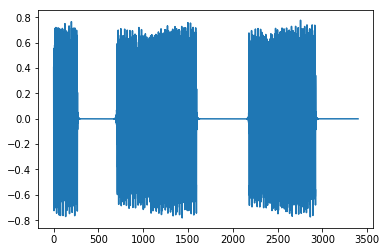

In [95]:
plt.plot(rec_original_signals[255,ending_sample_left_side-2000:ending_sample_left_side+1400])

21.589303016662598


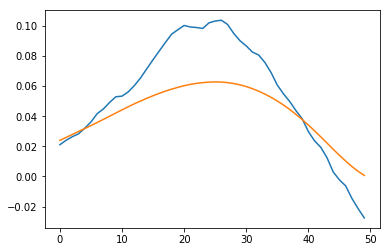

In [111]:
testOn = 20
plt.plot(generatedTimeSignals[testOn, 750:800])
plt.plot(originalTimeSignals[testOn, 750:800])
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

Text(0.5,1,'reconstructed')

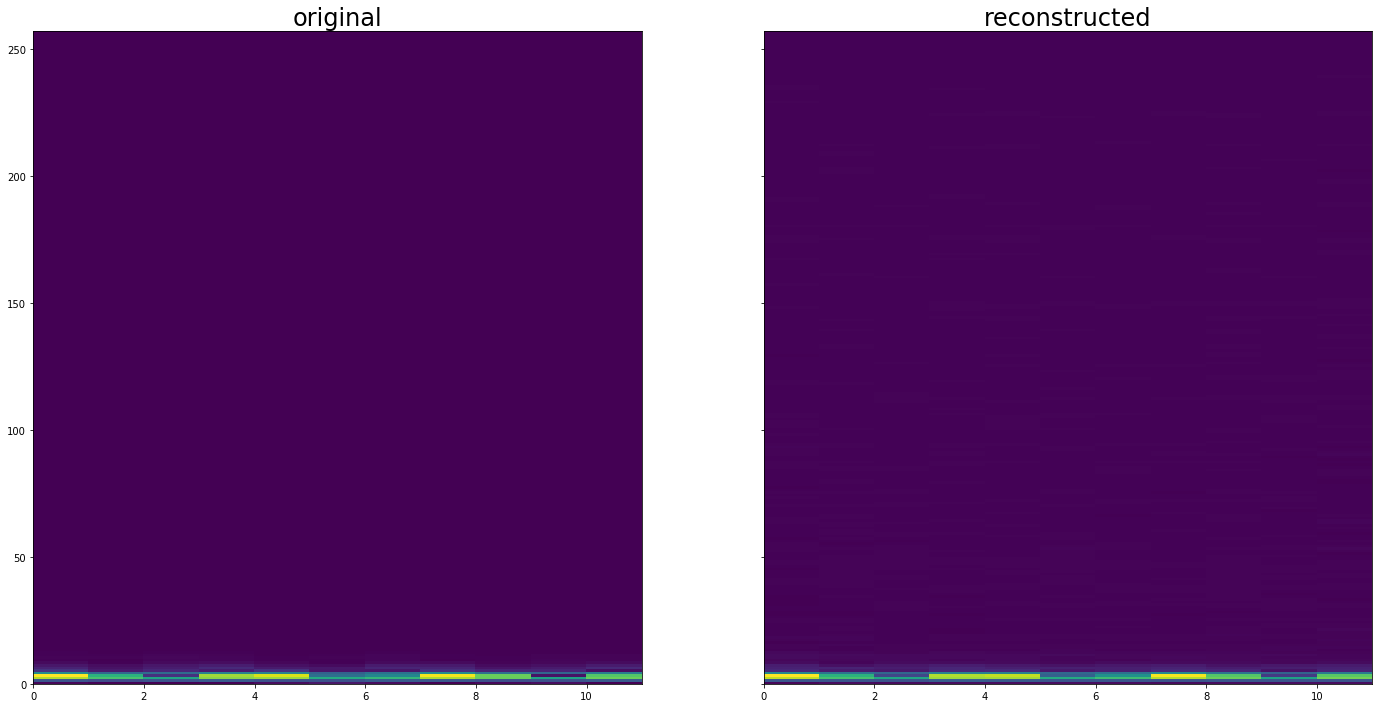

In [210]:
testOn = 50

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee

axarr[0].pcolormesh(stft[testOn].transpose())
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(generatedSpecs[0][testOn].transpose())
axarr[1].set_title('reconstructed', size=24)

In [202]:
generatedSpecs[0][10]==generatedSpecs[1][10]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [112]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed

SNRs = _pavlovs_SNR(generatedTimeSignals, originalTimeSignals, onAxis=(1,))
print(np.mean(SNRs))


12.152825


In [68]:
print(np.mean(_pavlovs_SNR(generatedTimeSignals[1000:], originalTimeSignals[1000:], onAxis=(1,))))


11.033775


c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([0.00035489, 0.        , 0.00017744, 0.        , 0.00017744,
        0.        , 0.        , 0.00017744, 0.00017744, 0.00017744,
        0.00035489, 0.00035489, 0.00124211, 0.00106466, 0.00798498,
        0.00141955, 0.00177444, 0.00141955, 0.00408121, 0.00408121,
        0.00532332, 0.00638799, 0.00567821, 0.00780754, 0.01064664,
        0.0193414 , 0.01685719, 0.02040607, 0.02218051, 0.02768127,
        0.02892338, 0.03477904, 0.03371437, 0.03123015, 0.03477904,
        0.03087527, 0.03087527, 0.03531137, 0.03531137, 0.03850536,
        0.03460159, 0.03992491, 0.02927827, 0.02306773, 0.02005118,
        0.01348575, 0.01117898, 0.01029176, 0.00709776, 0.00212933]),
 array([-38.31542587, -36.87188622, -35.42834656, -33.9848069 ,
        -32.54126724, -31.09772758, -29.65418793, -28.21064827,
        -26.76710861, -25.32356895, -23.8800293 , -22.43648964,
        -20.99294998, -19.54941032, -18.10587067, -16.66233101,
        -15.21879135, -13.77525169, -12.33171204, -10.88817238

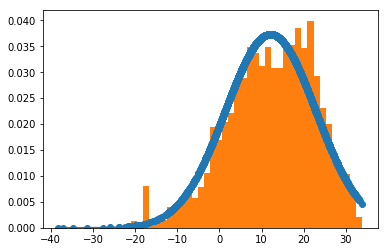

In [81]:
sorted_SNR = sorted(SNRs)

import scipy.stats as stats
fit = stats.norm.pdf(sorted_SNR, np.mean(sorted_SNR), np.std(sorted_SNR))  #this is a fitting indeed

plt.plot(sorted_SNR,fit,'-o')

plt.hist(sorted_SNR, 50, normed=True)    

In [84]:
print(np.where(SNRs<-10))

(array([ 255,  256,  257,  263,  264,  270,  271,  433,  539,  540,  541,
        709,  945,  959,  960,  961,  962,  963,  964,  970,  971,  973,
        979,  980,  981, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1476, 1942, 1947, 2030, 2034, 2039, 2045, 2048, 2481, 2483, 2484,
       2628, 2630, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2664,
       2665, 2666, 2667, 2668, 2767, 2941, 2943, 2944, 2945, 2946, 2948,
       2949, 2950, 2952, 2953, 2955, 3438, 3439, 3450, 3451, 3452, 3453,
       3454, 3851, 3852, 3854, 3859, 3860, 3861, 3863, 3865, 3866, 3870,
       3877, 3879, 3881, 3882, 3885, 3886, 3889, 3890, 3894, 3895, 3896,
       3897, 3901], dtype=int64),)
